<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **=== 0. Pytorch Domain Libraries ===**
1. Info
    https://pytorch.org/blog/new-library-updates-in-pytorch-2.0/
2. To do list
    1. torch vision : https://pytorch.org/vision/stable/
    2. torch audio : https://pytorch.org/audio/stable/
    3. torch rec : https://pytorch.org/torchrec/

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **=== 1. Get data ===**
1. 原資料集 : Food 101
    1. 101 classes
    2. 1000 images
2. 截取部分資料及內容 :
    1. https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb
    2. 3 classes
    3. 10% - 20% images of food 101

In [3]:
import requests
import zipfile
from pathlib import Path

# 設置資料路徑
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# 判斷資料夾存在與否
if image_path.is_dir():
    print(f"{image_path} directory already exist, skipping download")
else:
    print(f"{image_path} doesn't exist, creating")
    image_path.mkdir(parents=True, exist_ok=True)

# 下載壓縮檔
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

# 解壓縮
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the file")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist, creating
Unzipping the file


# 1.1 檢視資料結構
1. 注意資料夾與資料結構
2. train
    3 floders of different type images
3. test
    3 floders of different type images

In [4]:
# Walk function
import os

def walk_through_dir(dir_path):
    """Walk through dir_path, returning the content in it"""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} dirs and {len(filenames)} images in {dirpath}.")

In [5]:
# 資料結構
walk_through_dir(image_path)

There are 2 dirs and 0 images in data/pizza_steak_sushi.
There are 3 dirs and 0 images in data/pizza_steak_sushi/train.
There are 0 dirs and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 dirs and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 dirs and 75 images in data/pizza_steak_sushi/train/steak.
There are 3 dirs and 0 images in data/pizza_steak_sushi/test.
There are 0 dirs and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 dirs and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 dirs and 19 images in data/pizza_steak_sushi/test/steak.


In [6]:
# 圖片位置
print(image_path)

data/pizza_steak_sushi


In [7]:
# Setup training and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"train 路徑: {train_dir}")
print(f"test 路徑: {test_dir}")

train 路徑: data/pizza_steak_sushi/train
test 路徑: data/pizza_steak_sushi/test


# 1.2 檢視圖片

1. Get all of the image "path"
2. Pick random image path  (`random.choice()`)
3. Get image class name  (`pathlib.Path.parent.stem`)
4. Open image  (`PIL`)
5. Show image and print info

In [8]:
# 1. Get all image path
import random
from PIL import Image

# 設置 random seed
random.seed(42)

# "path" list
# image_path -> content/data/pizza_steak_sushi

image_path_list = list(image_path.glob("*/*/*.jpg"))  # 注意層數

In [9]:
# 2. Random pick
random_image_path = random.choice(image_path_list)
random_image_path

PosixPath('data/pizza_steak_sushi/train/sushi/2813454.jpg')

In [10]:
# 3. Get image class name
image_class = random_image_path.parent.stem
image_class

'sushi'

In [11]:
# 額外 : 如要選取路經中的檔案名稱
file_name = random_image_path.name
file_name

'2813454.jpg'

In [12]:
# 4. Show image
img = Image.open(random_image_path)

圖片路徑: data/pizza_steak_sushi/train/sushi/2813454.jpg
圖片類別: sushi | 名稱: 2813454.jpg
高: 512 | 寬: 512


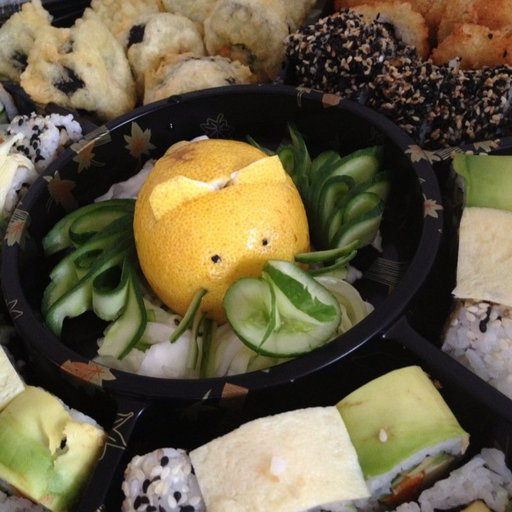

In [13]:
# 5. Show image and image_info

print(f"圖片路徑: {random_image_path}")
print(f"圖片類別: {image_class} | 名稱: {file_name}")
print(f"高: {img.height} | 寬: {img.width}")
img

# 1.2.1 檢視圖片 -> Matplotlib

(-0.5, 511.5, 511.5, -0.5)

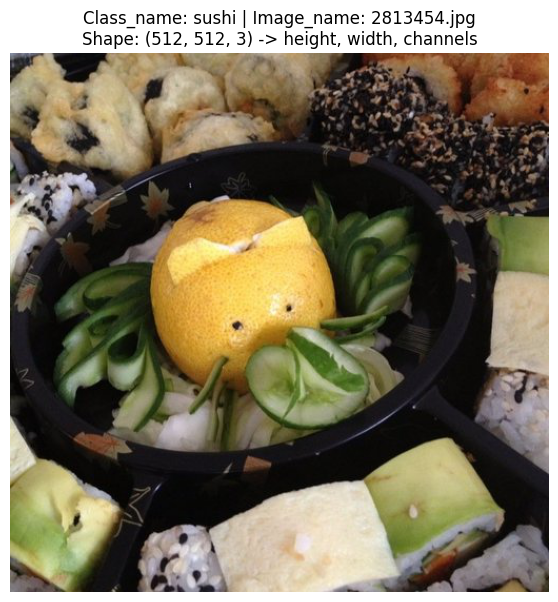

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image to array
img_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(7, 7))
plt.imshow(img_array)
plt.title(f"Class_name: {image_class} | Image_name: {file_name}\nShape: {img_array.shape} -> height, width, channels")
plt.axis("off")

# **=== 2. 資料預處理 & 資料增強===**

PyTorch 需要的資料型態 **tensor**
1. 將所有圖片都轉成 tensor
2. `torch.utils.data.Dataset`
    自定義資料集
3. `torch.utils.data.DataLoader`
    可迭代, 將資料及內容以批次的方式提供出來
4. 數據增強
    https://pytorch.org/vision/master/transforms.html
    1. `transforms.Resize(size)`
    2. `transforms.RandomHorizontalFlip(p)`
    3. `transforms.RandomVerticalFlip(p)`
    4. `transforms.RandomRotation(degrees)`
    5. `transforms.ColorJitter(brightness, contrast, saturation, hue)`
    對圖像的亮度、對比度、飽和度和色調進行隨機調整。
    6. `transforms.RandomCrop(size)`
    隨機從圖像中裁剪出指定大小的區域。
    7. `transforms.Normalize(mean, std)`



In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# transforms -> convert PIL or numpy image to tensor

In [16]:
# Write a "transform" for image
data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),        # resize 配合CNN 所需輸入
    transforms.RandomHorizontalFlip(p = 0.5),  # 水平翻轉 -> 資料增強
    transforms.ToTensor()                      # to tensor, 會同時將數據 "歸一化"
])

In [17]:
data_transform(img).shape

torch.Size([3, 64, 64])

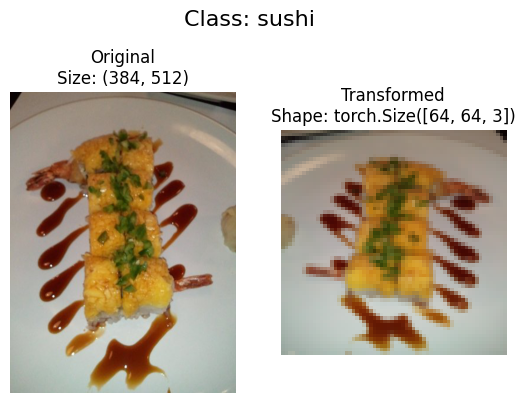

In [18]:
# 自定義一個 function 將 image_path_list 中的路徑 轉換成tensor
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    # check seed
    if seed:
        random.seed(seed)
    # 隨機選3張圖片轉換
    random_image_paths = random.sample(image_paths, k=n)

    # subplot
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)

            # 展示原圖
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis("off")

            # 展示轉換後的圖
            # 注意 : PIL vs matplotlib 將 channels 放在不同的位置 -> rearrange
            # permute
            transformed_image = data_transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            # 大標
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=1,
                        seed=None)

# 2.1 ImageFolder

https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html
1. `torchvision.datasets.ImageFolder`
2. Dataset ImageFolder -> classes
3. 自製一個類似 `torchvision.datasets.ImageFolder` 的功能





In [19]:
# Use ImageFolder to create dataset
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,  # for data
                                  target_transform = None)     # for label/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None)

train_dir, train_data, test_dir, test_data

(PosixPath('data/pizza_steak_sushi/train'),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 PosixPath('data/pizza_steak_sushi/test'),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [20]:
# Get class names -> list (內建的屬性)
class_list = train_data.classes
class_list

['pizza', 'steak', 'sushi']

In [21]:
# Get class names -> dict (內建的屬性)
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [22]:
# 內建屬性 : samples -> 返回路徑, 路徑label
train_data.samples[0:10]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0)]

# 2.1.1 ImageFolder 額外操作
1. Check info
2. Visualize

In [23]:
# train_data -> 每一個資料為tuple
# [0] -> 圖片 tensor
# [1] -> label

img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"\nImage shape: {img.shape} | Image label: {class_list[label]}" )
print(f"\nImage dtype: {img.dtype} | Label dtype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Before permute: torch.Size([3, 64, 64])
After permute: torch.Size([64, 64, 3])


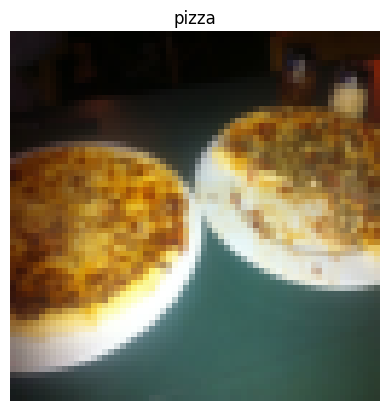

In [24]:
# Visualize
img_permute = img.permute(1, 2, 0)

# Check shapes
print(f"Before permute: {img.shape}")
print(f"After permute: {img_permute.shape}")

# Show image
plt.imshow(img_permute)
plt.title(class_list[label])
plt.gca().set_axis_off()

# **=== 3. Turn datasets to DataLoaders ===**
1. DataLoader -> iterables
2. DataLoader -> customize our batch size

In [25]:
# Trun train_data * test_data into DataLoader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# For train
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)  # 訓練時避免記憶

# For test
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7feb28b1f1c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7feb28b1f8e0>)

In [26]:
# 32 * 7 = 224  / 餘 1 -> 自己一個batch
len(train_dataloader)

8

In [27]:
# 確認 train_dataloader 作用
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} \n-> [batch_size, color_channels, height, width]")

print(f"\nLabel shape: {label.shape} \n-> [batch_size os label index]")

Image shape: torch.Size([32, 3, 64, 64]) 
-> [batch_size, color_channels, height, width]

Label shape: torch.Size([32]) 
-> [batch_size os label index]


# **=== 4. Data Augmentation ===**
https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [28]:
# trivailaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # 弱-強 0 - 31
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

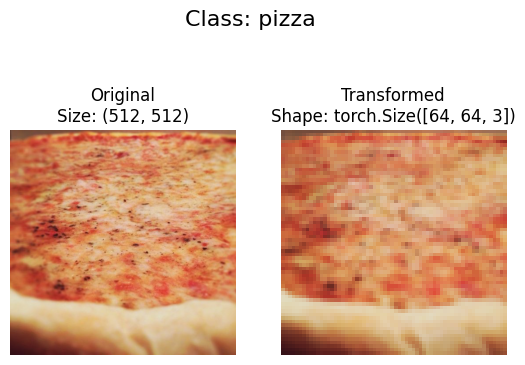

In [29]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=1,
                        seed=None)

# **=== 5. Model_0: TinyVGG without data augmentation ===**
Replicate TinyVGG architecture from the CNN Explainer
https://poloclub.github.io/cnn-explainer/

# 5.1 Creating transforms and loading data for Model_0

In [30]:
# Create simple transform
simple_transform = transforms.Compose([transforms.Resize(size = (64, 64)),
                                       transforms.ToTensor()
])

In [31]:
# 1. Load and transform data
from torchvision import datasets

# Load train data
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)

# Load test data
test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)

In [32]:
# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create train DataLoader
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

# Create test DataLoader
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

# 5.2 Set & Create Model_0 (TinyVGG)

In [33]:
# 設置模型架構
# subclass
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        # Blocks and Layers
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = (3, 3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3, 3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2, 2))
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3, 3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3, 3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2, 2))
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*16*16,
                      out_features = output_shape)
        )

    # Forward pass
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # 以下方法, GPU 在運算時, 記憶體消耗較少, 速度較快
        # self.classifier(self.conv_block_2(self.conv_block_1(x)))
        # return x

In [34]:
# 依照設置的架構 -> 建立模型
torch.manual_seed(42)

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_list)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

# 5.3 Using single batch to try forward pass
尚未訓練 -> 為了測試 Model_0 是否能夠正常運作

In [35]:
# Create single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [36]:
# Checking shape
model_0(image_batch.to(device))

# 模型調整前
# torch.Size([32, 10, 32, 32])
# torch.Size([32, 10, 16, 16])
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3)

# 原因 : hard code out classifier layer's in_features as hidden_units

# 調整
# hidden_units * 16 * 16

tensor([[0.0578, 0.0634, 0.0352],
        [0.0658, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0375],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0348],
        [0.0620, 0.0599, 0.0370],
        [0.0607, 0.0628, 0.0387],
        [0.0637, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0690, 0.0330],
        [0.0557, 0.0570, 0.0357],
        [0.0631, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0369],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0638, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

# 5.4 Checking Model_0 info
尚未訓練 -> 確認模型 summary
1. `torchinfo`

In [37]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# summary (model's name, input_size = batch's size)

summary(model_0, input_size = (32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

# 5.5 Setting function for training and testing model_0
1. `train_step()`
2. `test_step()`
3. `train()` function to combine `train_step()` & `test_step()` to train model

In [39]:
# Create train_step()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

    # Put model in train mode
    model.train()

    # Setup "train loss" & "train accuracy" -> accumulate each batch
    train_loss, train_acc = 0, 0

    # Loop through data loader / data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model_0(X)  # output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss = train_loss + loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc = train_acc + (y_pred_class==y).sum().item() / len(y_pred)

    # Adjust metrics -> to get average loss and average accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [40]:
# Create test_step()

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    # Put model in test mode
    model.eval()

    # Set "test loss" & "test accuracy"
    test_loss, test_acc = 0, 0

    # Inference mode
    with torch.inference_mode():
        # Loop through data loader / data batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss = test_loss + loss.item()

            # 3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc = test_acc + (test_pred_labels==y).sum().item() / len(test_pred_labels)


        # Adjust metrics -> to get average loss and average accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc


In [41]:
from tqdm.auto import tqdm

# 1. Create train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),  # 設置default
          epochs: int = 3):

    # 2. Create empty results dictionary
    # 用於記錄每 epoch result
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # 3. Loop through train step and test step
    for epoch in tqdm(range(epochs)):
        # train
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        # test
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(f"Epoch: {epoch}")
        print(f"Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f}")
        print(f"Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")

        # 5. Update results dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results dict
    return results

# 5.6 Actual train and eval model_0
1. Setting loss_fn
    確認損失函示
2. Setting optimizer
    確認優化器

In [42]:
# Set random seeds
# 僅為了教學影片的 可再現性 真實環境不需要此設定
torch.manual_seed(42)

In [44]:
# Set number of epochs
NUM_EPOCHS = 25

# Recreate TinyVGG (只是為了讓code集中, 方便複習)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set loss function
loss_fn = nn.CrossEntropyLoss()

# Set optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)  # lr 0.001 為PyTorch預設 "通常"效果較好

# Set timer
from timeit import default_timer as timer
start = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer
end = timer()
total_time_model_0 = end - start

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.110 | Train acc: 0.258
Test loss: 1.101 | Test acc: 0.240
Epoch: 1
Train loss: 1.091 | Train acc: 0.398
Test loss: 1.073 | Test acc: 0.542
Epoch: 2
Train loss: 1.081 | Train acc: 0.402
Test loss: 1.047 | Test acc: 0.542
Epoch: 3
Train loss: 1.099 | Train acc: 0.281
Test loss: 1.033 | Test acc: 0.542
Epoch: 4
Train loss: 1.070 | Train acc: 0.395
Test loss: 1.069 | Test acc: 0.443
Epoch: 5
Train loss: 1.076 | Train acc: 0.430
Test loss: 1.114 | Test acc: 0.312
Epoch: 6
Train loss: 0.988 | Train acc: 0.594
Test loss: 1.071 | Test acc: 0.434
Epoch: 7
Train loss: 0.953 | Train acc: 0.547
Test loss: 1.010 | Test acc: 0.455
Epoch: 8
Train loss: 0.853 | Train acc: 0.676
Test loss: 0.912 | Test acc: 0.594
Epoch: 9
Train loss: 0.768 | Train acc: 0.609
Test loss: 0.957 | Test acc: 0.442
Epoch: 10
Train loss: 0.880 | Train acc: 0.535
Test loss: 1.020 | Test acc: 0.505
Epoch: 11
Train loss: 0.803 | Train acc: 0.691
Test loss: 0.925 | Test acc: 0.513
Epoch: 12
Train loss: 0.79

In [ ]:
# 過擬合了

# **=== 6. Loss curve of Model_0 ===**

In [47]:
# 確認 model_0_results dict 內容
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [48]:
# 使用 model_0_results dict內的資料 製作圖表
def plot_loss_curves(results):
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]

    test_loss = results["test_loss"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    # Set plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train accuracy")
    plt.plot(epochs, test_acc, label="Test accuracy")
    plt.title("Accuraycy")
    plt.xlabel("Epochs")
    plt.ylabel("acc")
    plt.legend()

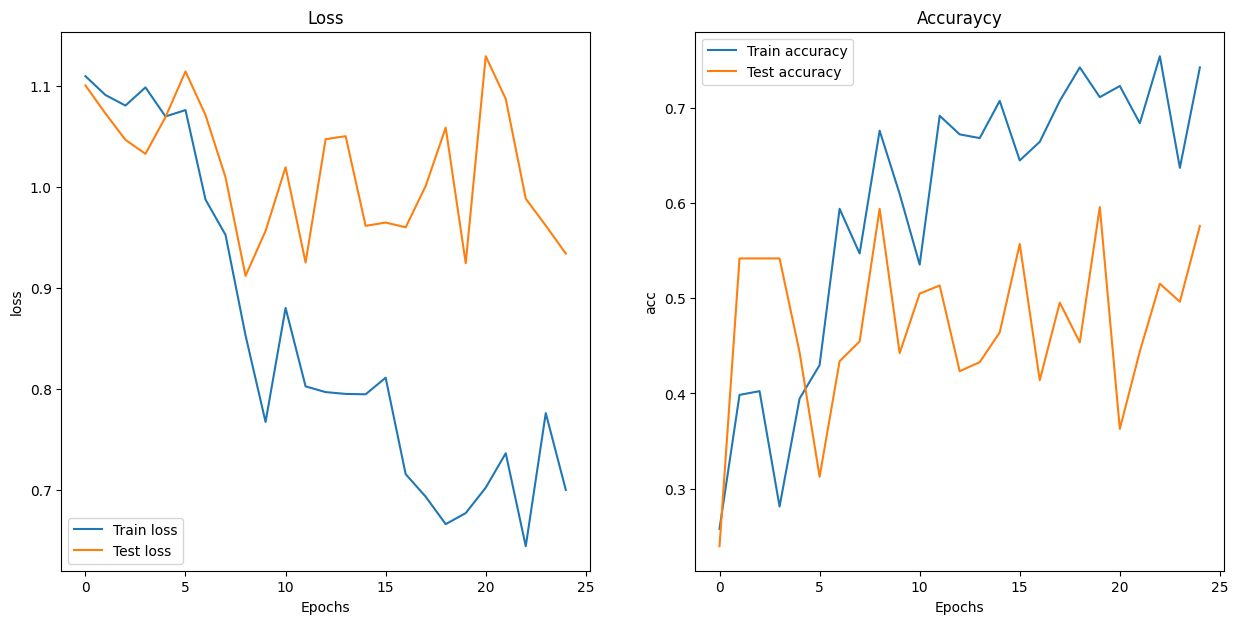

In [49]:
plot_loss_curves(model_0_results)